In [2]:
import pandas as pd
import chardet
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns #libreria para visualização de gráficos
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Charge and Exploration of the Dataset

In [3]:
def load_data(file_path):
    """
    Loads the data from a CSV file and performs an initial exploration.
    
    Args:
    file_path (str): Path to the CSV file containing the data.
    
    Returns:
    pd.DataFrame: DataFrame with the loaded data.
    """
    # Detect file encoding
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        encoding = result['encoding']

    print(f"Detected file encoding: {encoding}")

    try:
        # Try to read the file with the detected encoding
        data = pd.read_csv(file_path, encoding=encoding)
    except UnicodeDecodeError:
        print("Error with detected encoding. Trying 'latin-1' encoding...")
        try:
            # If that fails, try 'latin-1' encoding
            data = pd.read_csv(file_path, encoding='latin-1')
        except Exception as e:
            print(f"Error loading the file: {e}")
            return None

    print("Dataset dimensions:", data.shape)
    print("\nFirst 5 rows of the dataset:")
    print(data.head())
    print("\nDataset information:")
    print(data.info())
    print("\nDescriptive statistics:")
    print(data.describe())
    return data

## Reading genome.csv

In [4]:
data = load_data('.\csv\genomeTrainDisease.csv')

if data is not None:
    # Continúa con el procesamiento de los datos
    pass
else:
    print("No se pudieron cargar los datos. Por favor, verifica el archivo y su codificación.")

Detected file encoding: ISO-8859-1


C:\Users\JERON\AppData\Local\Temp\ipykernel_29752\564550034.py:21: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, encoding=encoding)


Dataset dimensions: (966977, 7)

First 5 rows of the dataset:
         rsid chromosome  position genotype  magnitude reputation summary
0   rs4477212          1     72017       AA        NaN        NaN     NaN
1   rs3094315          1    742429       AA        NaN        NaN     NaN
2   rs3131972          1    742584       GG        NaN        NaN     NaN
3  rs12124819          1    766409       AA        NaN        NaN     NaN
4  rs11240777          1    788822       AG        NaN        NaN     NaN

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966977 entries, 0 to 966976
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   rsid        966977 non-null  object 
 1   chromosome  966977 non-null  object 
 2   position    966977 non-null  int64  
 3   genotype    966977 non-null  object 
 4   magnitude   1392 non-null    float64
 5   reputation  934 non-null     object 
 6   summary     982 non-n

# Data Preprocesing
## Cleaning the data

In [5]:
def clean_data(data):
    """
    Cleans the data by handling missing values and verifying the distribution.
    
    Args:
    data (pd.DataFrame): Original DataFrame.
    
    Returns:
    pd.DataFrame: Cleaned DataFrame.
    """
    
    print("Missing values for columns:")
    print(data.isnull().sum())

    # Handle missing values for numeric columns
    numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_columns) > 0:
        numeric_imputer = SimpleImputer(strategy='mean')
        data[numeric_columns] = numeric_imputer.fit_transform(data[numeric_columns])

    # Handle missing values for categorical columns (including 'genotype')
    categorical_columns = data.select_dtypes(include=['object']).columns
    if len(categorical_columns) > 0:
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        data[categorical_columns] = categorical_imputer.fit_transform(data[categorical_columns])

    print("\nDistribution of genotypes:")
    print(data['genotype'].value_counts(normalize=True))

    # Check for any remaining missing values
    print("\nRemaining missing values:")
    print(data.isnull().sum())

    return data


data_clean = clean_data(data)

Missing values for columns:
rsid               0
chromosome         0
position           0
genotype           0
magnitude     965585
reputation    966043
summary       965995
dtype: int64

Distribution of genotypes:
genotype
CC    0.180192
GG    0.179433
TT    0.152389
AA    0.152314
CT    0.119876
AG    0.119552
GT    0.027953
AC    0.027739
C     0.008156
G     0.008005
A     0.007474
T     0.007386
--    0.006541
CG    0.001208
II    0.000754
AT    0.000654
DD    0.000184
I     0.000123
D     0.000048
DI    0.000019
Name: proportion, dtype: float64

Remaining missing values:
rsid          0
chromosome    0
position      0
genotype      0
magnitude     0
reputation    0
summary       0
dtype: int64


## Processing data

In [6]:
def preprocess_data(data):
    """
    Realiza el preprocesamiento de los datos, incluyendo codificación one-hot y escalado.
    
    Args:
    data (pd.DataFrame): DataFrame limpio.
    
    Returns:
    tuple: X_processed (features procesadas), preprocessor (ColumnTransformer)
    """
    print("Iniciando preprocesamiento...")
    print("Columnas en el DataFrame:", data.columns)
    print("Tipos de datos:")
    print(data.dtypes)
    
    # Crear preprocesador
    numeric_features = ['chromosome', 'position']
    categorical_features = ['genotype']
    
    print("Características numéricas:", numeric_features)
    print("Características categóricas:", categorical_features)
    
    # Convertir 'chromosome' y 'position' a tipo numérico si no lo son
    data['chromosome'] = pd.to_numeric(data['chromosome'], errors='coerce')
    data['position'] = pd.to_numeric(data['position'], errors='coerce')
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    print("Aplicando preprocesamiento...")
    # Ajustar y transformar
    try:
        X_processed = preprocessor.fit_transform(data)
        print("Preprocesamiento completado con éxito.")
    except Exception as e:
        print("Error durante el preprocesamiento:")
        print(str(e))
        raise
    
    print("Obteniendo nombres de características...")
    # Obtener nombres de características después del preprocesamiento
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    feature_names = (numeric_features + 
                     onehot_encoder.get_feature_names_out(categorical_features).tolist())
    
    X_processed_df = pd.DataFrame(X_processed, columns=feature_names)
    
    print("Dimensiones de X después del preprocesamiento:", X_processed_df.shape)
    print("\nPrimeras 5 filas de X preprocesado:")
    print(X_processed_df.head())
    
    return X_processed_df, preprocessor

# Aplicar
try:
    X_processed, preprocessor = preprocess_data(data_clean)
    print("Preprocesamiento completado exitosamente.")
except Exception as e:
    print("Error al aplicar el preprocesamiento:")
    print(str(e))

Iniciando preprocesamiento...
Columnas en el DataFrame: Index(['rsid', 'chromosome', 'position', 'genotype', 'magnitude', 'reputation',
       'summary'],
      dtype='object')
Tipos de datos:
rsid           object
chromosome     object
position      float64
genotype       object
magnitude     float64
reputation     object
summary        object
dtype: object
Características numéricas: ['chromosome', 'position']
Características categóricas: ['genotype']
Aplicando preprocesamiento...
Preprocesamiento completado con éxito.
Obteniendo nombres de características...
Dimensiones de X después del preprocesamiento: (966977, 21)

Primeras 5 filas de X preprocesado:
   chromosome  position  genotype_A  genotype_AA  genotype_AC  genotype_AG  \
0   -1.362345 -1.358799         0.0          1.0          0.0          0.0   
1   -1.362345 -1.346914         0.0          1.0          0.0          0.0   
2   -1.362345 -1.346912         0.0          0.0          0.0          0.0   
3   -1.362345 -1.346489 

# Vizualice data cleaning

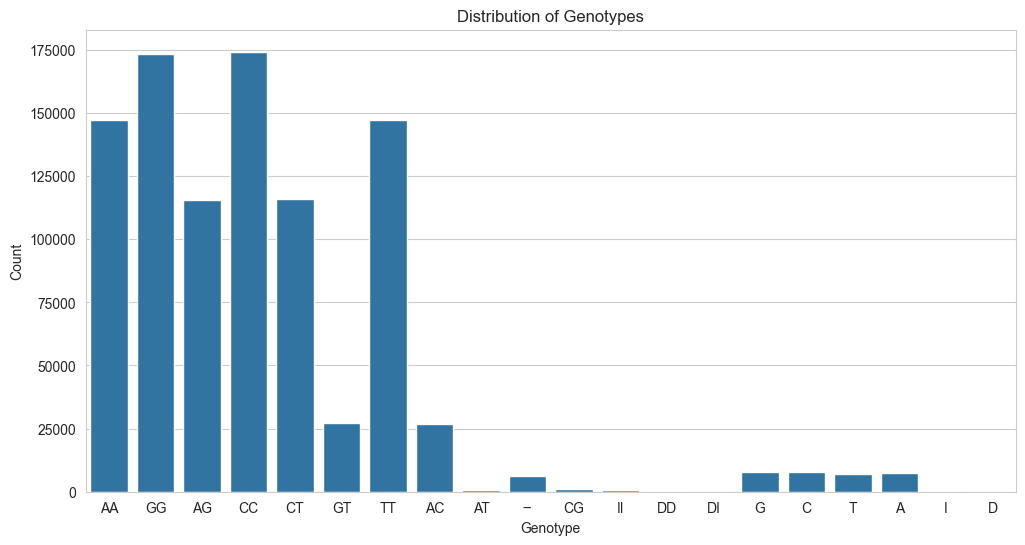

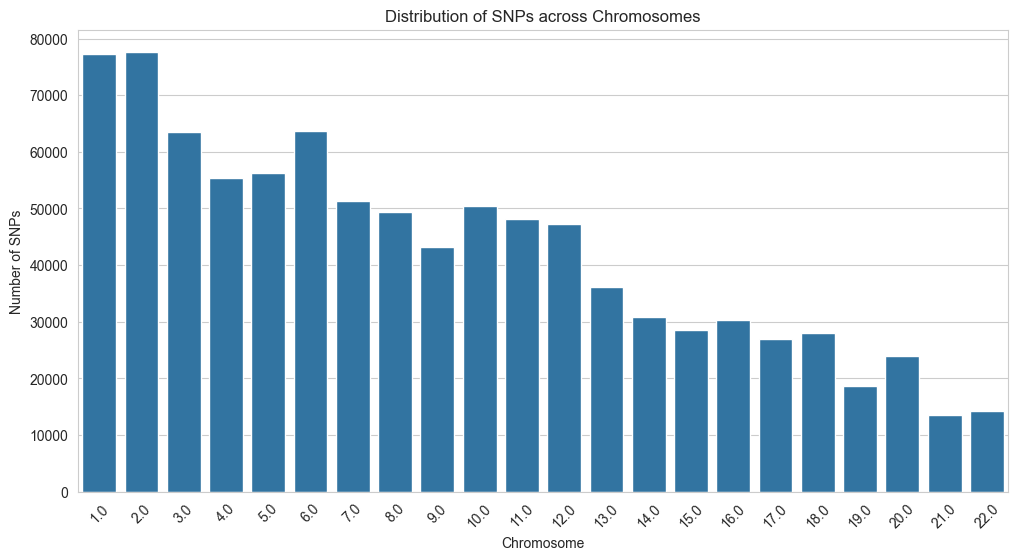

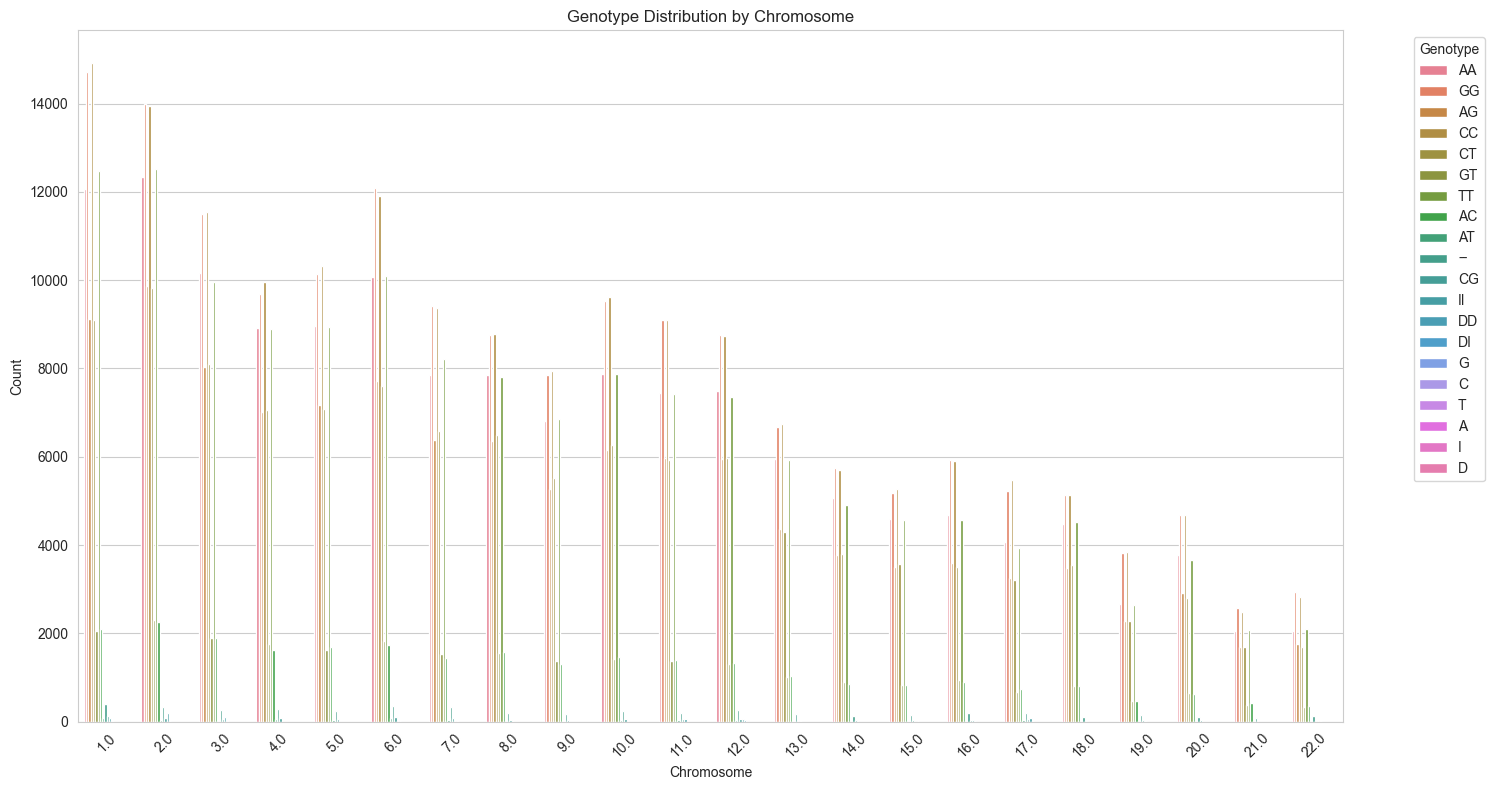

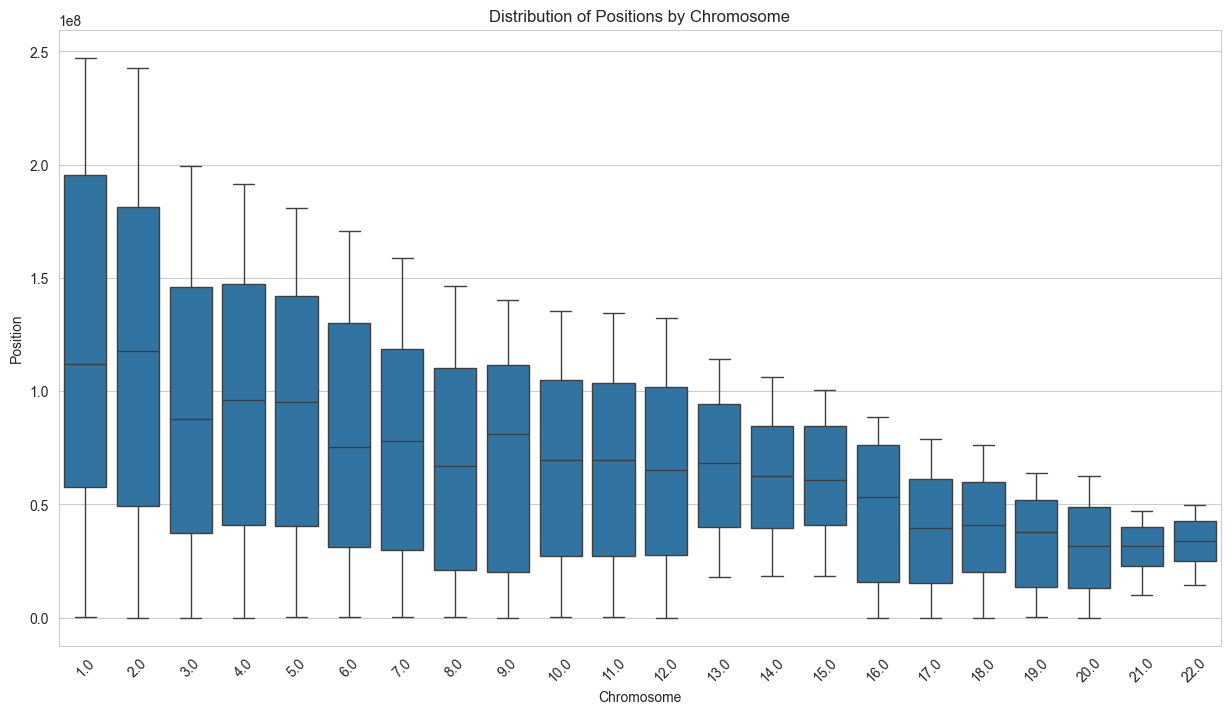

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_data(data):
    """
    Creates visualizations to explore the genomic data.
    
    Args:
    data (pd.DataFrame): DataFrame with columns: rsid, chromosome, position, genotype, magnitude, reputation, summary
    """
    
    # Set the style for better-looking plots
    sns.set_style("whitegrid")
    
    # 1. Distribution of Genotypes
    plt.figure(figsize=(12, 6))
    sns.countplot(x='genotype', data=data)
    plt.title('Distribution of Genotypes')
    plt.xlabel('Genotype')
    plt.ylabel('Count')
    plt.show()
    
    # 2. Distribution of Chromosomes
    plt.figure(figsize=(12, 6))
    chromosome_counts = data['chromosome'].value_counts().sort_index()
    sns.barplot(x=chromosome_counts.index, y=chromosome_counts.values)
    plt.title('Distribution of SNPs across Chromosomes')
    plt.xlabel('Chromosome')
    plt.ylabel('Number of SNPs')
    plt.xticks(rotation=45)
    plt.show()
    
    # 3. Genotype Distribution by Chromosome
    plt.figure(figsize=(15, 8))
    sns.countplot(x='chromosome', hue='genotype', data=data)
    plt.title('Genotype Distribution by Chromosome')
    plt.xlabel('Chromosome')
    plt.ylabel('Count')
    plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 4. Position Distribution by Chromosome
    plt.figure(figsize=(15, 8))
    sns.boxplot(x='chromosome', y='position', data=data)
    plt.title('Distribution of Positions by Chromosome')
    plt.xlabel('Chromosome')
    plt.ylabel('Position')
    plt.xticks(rotation=45)
    plt.show()
    
    # 5. Scatter plot of Position vs Magnitude (if available)
    if 'magnitude' in data.columns and data['magnitude'].notna().any():
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=data, x='position', y='magnitude', hue='chromosome')
        plt.title('Position vs Magnitude by Chromosome')
        plt.xlabel('Position')
        plt.ylabel('Magnitude')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

visualize_data(data_clean)

# Correlation Analisis of numeric features
## Importance of Correlation Analysis

El análisis de correlación es crucial en el preprocesamiento de datos y el análisis exploratorio de datos (AED). Ayuda a:

1. **Identificar relaciones**: Comprender la relación entre las características numéricas puede ayudar a mejorar el rendimiento del modelo al resaltar qué características están correlacionadas positiva o negativamente.
2. 2. **Selección de características**: Las características muy correlacionadas pueden proporcionar información redundante. La eliminación de tales características puede reducir la complejidad del modelo sin perder mucha información.
3. **Detección de multicolinealidad**: En los modelos de regresión, la multicolinealidad (cuando dos o más predictores están altamente correlacionados) puede hacer que las estimaciones de los parámetros sean inestables e inflar los errores estándar. La detección temprana de la multicolinealidad permite realizar los ajustes oportunos.

## Performing Correlation Analysis
Para realizar un análisis de correlación entre características numéricas, siga estos pasos:

1. **Seleccionar características numéricas**: En este caso, seleccionamos 'cromosoma' y 'posición' del conjunto de datos.
 2. **Calcular la matriz de correlación**: Utilizar el método `corr()` proporcionado por pandas para calcular la matriz de correlaciones, que muestra los coeficientes de correlación entre pares de características.
3. **Visualizar Correlación**: Se genera un mapa de calor utilizando la función `heatmap()` de seaborn. Esta representación visual ayuda a identificar rápidamente los patrones de correlación y la fuerza de las relaciones.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def analyze_correlation(data):
    """
    Performs a correlation analysis among numeric features and additional clustering analysis.
    
    Args:
    data (pd.DataFrame): DataFrame with columns including chromosome, position, reputation
    """
    # Traditional correlation analysis
    numeric_data = data[['chromosome', 'position']]
    if 'magnitude' in data.columns and data['magnitude'].notna().any():
        numeric_data['magnitude'] = data['magnitude']
    if 'reputation' in data.columns and data['reputation'].notna().any():
        numeric_data['reputation'] = data['reputation']
    
    corr_matrix = numeric_data.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Matrix of Numeric Features')
    plt.show()

    # K-means analysis for reputation and chromosome relationship
    if 'reputation' in data.columns and data['reputation'].notna().any():
        # Prepare data for k-means
        X = data[['chromosome', 'reputation']].copy()
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Determine optimal number of clusters using elbow method
        inertias = []
        K = range(1, 10)
        for k in K:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(X_scaled)
            inertias.append(kmeans.inertia_)
        
        # Plot elbow curve
        plt.figure(figsize=(10, 6))
        plt.plot(K, inertias, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Inertia')
        plt.title('Elbow Method For Optimal k')
        plt.show()
        
        # Perform k-means clustering with optimal k (let's use k=3 for this example)
        kmeans = KMeans(n_clusters=3, random_state=42)
        clusters = kmeans.fit_predict(X_scaled)
        
        # Visualize clusters
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(data['chromosome'], data['reputation'], 
                            c=clusters, cmap='viridis')
        plt.xlabel('Chromosome')
        plt.ylabel('Reputation')
        plt.title('K-means Clustering of Chromosome vs Reputation')
        plt.colorbar(scatter, label='Cluster')
        plt.show()

        # Additional analysis: Distribution of clusters by chromosome
        cluster_df = pd.DataFrame({
            'Chromosome': data['chromosome'],
            'Cluster': clusters
        })
        
        plt.figure(figsize=(12, 6))
        cluster_counts = pd.crosstab(cluster_df['Chromosome'], cluster_df['Cluster'])
        cluster_counts.plot(kind='bar', stacked=True)
        plt.title('Distribution of Clusters Across Chromosomes')
        plt.xlabel('Chromosome')
        plt.ylabel('Count')
        plt.legend(title='Cluster')
        plt.tight_layout()
        plt.show()

        # Print cluster statistics
        print("\nCluster Statistics:")
        cluster_stats = data.groupby(clusters).agg({
            'chromosome': ['mean', 'count'],
            'reputation': ['mean', 'std']
        }).round(2)
        print(cluster_stats)
    else:
        print("\nNote: Reputation data is not available for clustering analysis")

analyze_correlation(data_clean)

- Paso 1**: Extrae datos numéricos de las columnas 'cromosoma' y 'posición'.
- Paso 2**: Calcula la matriz de correlaciones utilizando el método `corr()` de pandas.
- Paso 3**: Traza la matriz de correlación usando `heatmap()` de seaborn, donde:
  - `annot=True` muestra los coeficientes de correlación.
  - `cmap='coolwarm'` especifica el mapa de colores.
  - vmin=-1` y `vmax=1` establecen el rango de la escala de color.
  - `center=0` asegura que el mapa de color está centrado alrededor de cero.

facilitamos de esta forma la interpretación de los resultados.

# SNPs distribution by Chromosome

In [1]:

def analyze_snp_distribution(data):
    """
    Analyzes the distribution of SNPs across chromosomes.
    Args:
    data (pd.DataFrame): DataFrame origi
    """
    snp_counts = data['chromosome'].value_counts().sort_index()
    
    plt.figure(figsize=(15, 6))
    sns.barplot(x=snp_counts.index, y=snp_counts.values)
    plt.title('Distribución de SNPs por Cromosoma')
    plt.xlabel('Cromosoma')
    plt.ylabel('Número de SNPs')
    plt.xticks(rotation=0)
    plt.show()

analyze_snp_distribution(data_clean)

NameError: name 'data_clean' is not defined

# Stadistic resume for chromosome

In [ ]:
def summarize_by_chromosome(data):
    """
    generates a summary of the dataset by chromosome
    
    Args:
    data (pd.DataFrame): DataFrame original.
    
    Returns:
    pd.DataFrame: summary of the dataset by chromosome
    """
    summary = data.groupby('chromosome')['position'].agg(['min', 'max', 'mean', 'median', 'std']).reset_index()
    summary.columns = ['Cromosoma', 'Posición Mínima', 'Posición Máxima', 'Posición Media', 'Posición Mediana', 'Desviación Estándar']
    return summary

chromosome_summary = summarize_by_chromosome(data_clean)
print(chromosome_summary)

# Save Preprocessed Data

In [ ]:
def save_processed_data(data, file_path):
  """
  Saves the preprocessed data to a CSV file.
  
  Args:
  data (pd.DataFrame): DataFrame with preprocessed data.
  file_path (str): Path where the CSV file will be saved.
  """
  data.to_csv(file_path, index=False)
  print(f"Preprocessed data saved to {file_path}")

save_processed_data(X_processed, '.\processed_genetic_data.csv')

print("Exploratory analysis and preprocessing completed.")

### ¿Qué representa este conjunto de datos final?

1. **Cromosoma y Posición:**
   - Cada fila del conjunto de datos representa una **sección específica del ADN** de una persona. 
   - El **cromosoma** indica en qué parte del genoma estamos observando. Hay 23 pares de cromosomas en los humanos, y estos datos están normalizados o "escalados" para facilitar el procesamiento en un modelo.
   - La **posición** indica el lugar exacto dentro del cromosoma donde estamos observando una variación genética importante, también escalada.

2. **Genotipos:**
   - Cada persona hereda una combinación de ADN de sus padres, y cada sección de ADN puede contener diferentes combinaciones de "letras" (A, C, G, T, que son las bases del ADN).
   - En este conjunto de datos, los **genotipos** (o combinaciones genéticas) están codificados de una manera que las computadoras pueden entender fácilmente, usando lo que se llama **one-hot encoding**. Básicamente, una columna para cada posible combinación de letras (AA, AG, CC, GT, etc.), y se marca un **1** si esa combinación está presente o un **0** si no lo está.
   - También hay variaciones como deleciones (cuando falta una parte del ADN, marcado como **D**) o inserciones (cuando hay ADN adicional, marcado como **I**).

3. **Ejemplo de cómo interpretar una fila:**
   - **Cromosoma:** `-1.36` (escalado, pero indica un cromosoma específico, como el 7 por ejemplo).
   - **Posición:** `-1.35` (indica una posición específica en ese cromosoma).
   - **Genotipo_AA:** `1.0` (esto significa que en esta posición, la persona tiene la combinación de letras "AA").
   - **Genotipo_AG, GT, CC, etc.:** `0.0` (esto significa que otras combinaciones de letras no están presentes en esta posición).

### ¿Por qué es importante este formato?

- **Escalado de Datos Numéricos:** Los valores de cromosoma y posición están escalados para que todas las variables numéricas tengan una escala similar, lo que ayuda a que el algoritmo de machine learning no favorezca una sobre otra.
  
- **Codificación One-Hot:** Al codificar los genotipos en múltiples columnas con valores de 0 y 1, el modelo puede procesar estas combinaciones genéticas de manera eficiente, aprendiendo cuáles son más importantes para predecir una enfermedad.

- **Permitir Variantes Genéticas Complejas:** No solo consideramos combinaciones básicas (AA, AG, etc.), sino también variantes estructurales como inserciones y deleciones, que pueden tener un impacto significativo en el desarrollo de enfermedades.

Este conjunto de datos es el punto de partida para que una red neuronal o un modelo de aprendizaje automático aprenda qué combinaciones genéticas están asociadas con una enfermedad específica.